In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix 
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix, vstack
import matplotlib.pyplot as plt
from collections import defaultdict


In [2]:
# Load data
game_df=pd.read_pickle('user_item.pkl')
game_df.rename(columns={'steam_id':'user_id'},inplace=True)
user_id2=pd.factorize(game_df.user_id)
user_dict1=dict(zip(user_id2[0],game_df.user_id))
game_df['user_id2']=user_id2[0]
# re-arrange item id start from 1 call it item2
item_id2=pd.factorize(game_df.item_id)
item_dict1=dict(zip(item_id2[0],game_df.item_id))
game_df['item_id2']=item_id2[0]
ui_df_full=game_df[['user_id2','item_id2']]

In [3]:
def scale_impact(mysize,mypercent,rand_state):
    # First sample mysize user because the dataset is too large
    np.random.seed(rand_state)
    select_user_df=np.random.choice(ui_df_full.user_id2.unique(),replace=False,size=mysize)
    user_sample=ui_df_full[ui_df_full['user_id2'].isin(select_user_df)]
    user_sample.info()
    # Then sample 70% user item pairs base on user
    user_sample=user_sample.groupby('user_id2').apply(lambda x: x.sample(int(len(x)*mypercent))).copy().reset_index(drop=True)
    user_id2=pd.factorize(user_sample.user_id2)
    item_id2=pd.factorize(user_sample.item_id2)
    user_dict2=dict(zip(user_id2[0],user_sample.user_id2))
    user_sample['user_id2']=user_id2[0]
    print('num of user',len(user_dict2))
    item_dict2=dict(zip(item_id2[0],user_sample.item_id2))
    user_sample['item_id2']=item_id2[0]
    print('num of item',len(item_dict2))
    # Store the total num of user and item
    all_u=len(user_sample.user_id2.unique())
    all_i=len(user_sample.item_id2.unique())

    def pred_vect(vect,sim_vector,vect_pool):
        pred_vect=np.zeros(len(vect))
        allweights=0
        de_similarity=sorted(sim_vector,reverse=True)[1:]
        index_sort=np.argsort(sim_vector)[::-1][1:]
        for index in index_sort[:10]:
            pred_vect+=vect_pool[index]*sim_vector[index]
            allweights+=abs(sim_vector[index])
        if allweights!=0:
            pred_vect=pred_vect/allweights

        return pred_vect

    def vectorize_u(tidylist):        
        tidylist=np.unique(tidylist)
        row = np.zeros(len(tidylist),dtype=np.int8)
        col = tidylist
        data = np.ones(len(tidylist),dtype=np.int8)
        return csr_matrix((data, (row, col)),shape=(1,all_i))

    user_vector=user_sample.groupby('user_id2')['item_id2'].apply(vectorize_u)
    user_mtx=vstack(np.array(user_vector))
    user_cos=cosine_similarity(user_mtx)
    user_mtx=user_mtx.toarray()

    def onetest_user(useri,benchmark):
        test=pred_vect(user_mtx[useri],user_cos[useri],user_mtx)
        positive_test=[x for x in test if x>benchmark]
        # We only test entries larger than benchmark
        # return a list of items that the user might consume
    #     print(sorted(test)[::-1][:len(positive_test)])
        return np.argsort(test)[::-1][:len(positive_test)]
    def one_user_accuracy(useri,benchmark,coverage_K):
        coverage=0
        useri_pred=onetest_user(useri,benchmark)
        trained_item=user_sample[user_sample.user_id2==useri]['item_id2']
        trained_set=set(item_dict1[y] for y in [item_dict2[x] for x in list(trained_item)])
        true_item=set(game_df[game_df['user_id2']==user_dict2[useri]]['item_id'])-trained_set
        pred_item=set(item_dict1[y] for y in [item_dict2[x] for x in useri_pred])-trained_set
        if len(true_item.intersection(pred_item))>=coverage_K:
            coverage=1
        if len(pred_item)!=0 and len(true_item)!=0:
            accuracy=len(true_item.intersection(pred_item))/len(true_item.union(pred_item))
            error=1-accuracy
            precision=len(true_item.intersection(pred_item))/len(pred_item)
            recall=len(true_item.intersection(pred_item))/len(true_item)
            return error,precision,recall,coverage

    RMSE_list=[]
    benchmark_list=[]
    coverage_list=[]
    recall_list=[]
    precision_list=[]
    RMSE_list=[]
    for i in range(0,6):
        benchmark=i/10
        benchmark_list+=[benchmark]
        SE=[]
        mean_coverage=[]
        mean_recall=[]
        mean_precision=[]
        for useri in range(all_u):
            try:
                error,precision,recall,coverage =one_user_accuracy(useri,benchmark,5)
                SE+=[error**2]
                mean_coverage+=[coverage]
                mean_recall+=[recall]
                mean_precision+=[precision]
            except:
                continue
        coverage_list+=[np.mean(mean_coverage)]
        RMSE_list+=[np.sqrt(np.mean(SE))]
        recall_list+=[np.mean(mean_recall)]
        precision_list+=[np.mean(mean_precision)]
        
        print("when benchmark = {}, coverage ={}, RMSE={},recall={},precision={}".format(i/10,coverage_list[-1],RMSE_list[-1],recall_list[-1],precision_list[-1]))
    plt.figure(figsize=(10,5))
    plt.plot(benchmark_list,RMSE_list,label="RMSE")
    plt.plot(benchmark_list,coverage_list,label='coverage')
    plt.plot(benchmark_list,recall_list,label='recall')
    plt.plot(benchmark_list,precision_list,label='precision')
    plt.legend(loc='upper right', shadow=True, ncol=1)
    plt.show()
    return (benchmark_list,RMSE_list,coverage_list,recall_list,precision_list)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 175758 to 5149260
Data columns (total 2 columns):
user_id2    2080 non-null int64
item_id2    2080 non-null int64
dtypes: int64(2)
memory usage: 48.8 KB
num of user 28
num of item 861
when benchmark = 0.0, coverage =0.7857142857142857, RMSE=0.9714115666593123,recall=0.5479666213158491,precision=0.030850375753819544
when benchmark = 0.1, coverage =0.6428571428571429, RMSE=0.9580792693069252,recall=0.38920209481201035,precision=0.048178846168447864
when benchmark = 0.2, coverage =0.32142857142857145, RMSE=0.9299028119961219,recall=0.23824197944991785,precision=0.11204599746407816
when benchmark = 0.3, coverage =0.17857142857142858, RMSE=0.9278019163563084,recall=0.13645377265498074,precision=0.19761867803801683
when benchmark = 0.4, coverage =0.07407407407407407, RMSE=0.9278334126823495,recall=0.10265357371137993,precision=0.35367698145475923
when benchmark = 0.5, coverage =0.0, RMSE=0.9460958709079905,recall=0.0754582743009

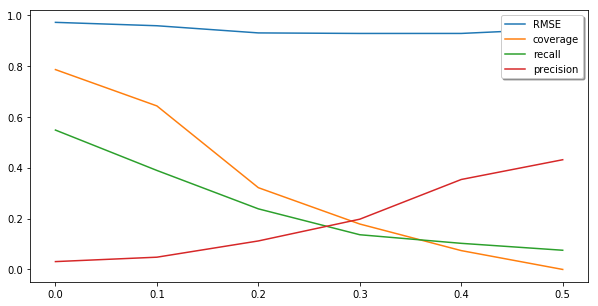

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21814 entries, 62828 to 5150596
Data columns (total 2 columns):
user_id2    21814 non-null int64
item_id2    21814 non-null int64
dtypes: int64(2)
memory usage: 511.3 KB
num of user 275
num of item 2903
when benchmark = 0.0, coverage =0.6, RMSE=0.9612788750786112,recall=0.57224700996927,precision=0.04083341841561825
when benchmark = 0.1, coverage =0.5236363636363637, RMSE=0.9391170302091602,recall=0.43257474884005537,precision=0.06970075257336916
when benchmark = 0.2, coverage =0.46153846153846156, RMSE=0.8950807081477659,recall=0.298663366745419,precision=0.16611792219680863
when benchmark = 0.3, coverage =0.325, RMSE=0.8846443231731751,recall=0.21008222028502094,precision=0.28479445609055093
when benchmark = 0.4, coverage =0.23267326732673269, RMSE=0.8979534474695471,recall=0.1500255537514312,precision=0.4159921865833574
when benchmark = 0.5, coverage =0.16666666666666666, RMSE=0.9282668871294721,recall=0.09557880791687051,precision=0

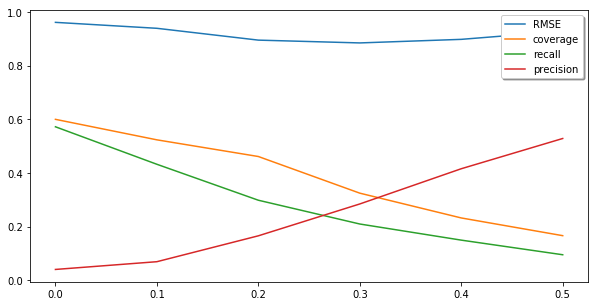

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215117 entries, 4172 to 5152599
Data columns (total 2 columns):
user_id2    215117 non-null int64
item_id2    215117 non-null int64
dtypes: int64(2)
memory usage: 4.9 MB
num of user 2849
num of item 6281
when benchmark = 0.0, coverage =0.5867474171713574, RMSE=0.9374064412202635,recall=0.5046404393957435,precision=0.07087237355417701
when benchmark = 0.1, coverage =0.5210332103321034, RMSE=0.9080689592561205,recall=0.387811346121341,precision=0.1252132720754779
when benchmark = 0.2, coverage =0.44298605414273995, RMSE=0.8663163884410268,recall=0.2777163332454791,precision=0.26512504089120204
when benchmark = 0.3, coverage =0.37980085348506404, RMSE=0.8676005746671992,recall=0.2011968169934416,precision=0.39138821730176426
when benchmark = 0.4, coverage =0.3103644646924829, RMSE=0.8823474207404414,recall=0.152529093434363,precision=0.5104497948955695
when benchmark = 0.5, coverage =0.2374461979913917, RMSE=0.9051446481935558,recall=0.112

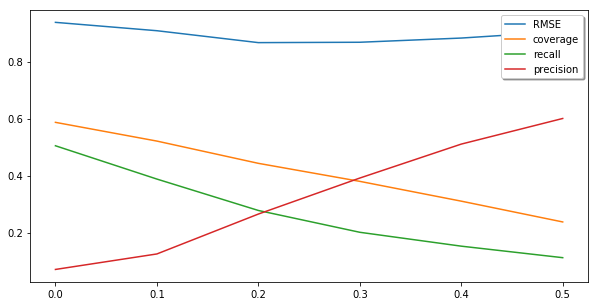

([0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
 [0.9374064412202635,
  0.9080689592561205,
  0.8663163884410268,
  0.8676005746671992,
  0.8823474207404414,
  0.9051446481935558],
 [0.5867474171713574,
  0.5210332103321034,
  0.44298605414273995,
  0.37980085348506404,
  0.3103644646924829,
  0.2374461979913917],
 [0.5046404393957435,
  0.387811346121341,
  0.2777163332454791,
  0.2011968169934416,
  0.152529093434363,
  0.11214245556138389],
 [0.07087237355417701,
  0.1252132720754779,
  0.26512504089120204,
  0.39138821730176426,
  0.5104497948955695,
  0.6003129191359163])

In [4]:
scale_impact(30,0.7,200)
scale_impact(300,0.7,200)
scale_impact(3000,0.7,200)

In [5]:
def crossvalidation(Ntimes,mysize,mypercent,rand_state):
    benchmark=[]
    RMSE=[]
    coverage=[]
    recall=[]
    precision=[]
    for i in range(Ntimes):
        benchmark_list,RMSE_list,coverage_list,recall_list,precision_list=scale_impact(mysize,mypercent,rand_state)
        benchmark+=[benchmark_list]
        RMSE+=[RMSE_list]
        coverage+=[coverage_list]
        recall+=[recall_list]
        precision+=[precision_list]

    cv_benchmark=np.average(benchmark ,axis=0)
    cv_RMSE=np.average(RMSE ,axis=0)
    cv_coverage=np.average(coverage,axis=0)
    cv_recall=np.average(recall,axis=0)
    cv_precision=np.average(precision,axis=0)
    plt.figure(figsize=(10,5))
#     print(cv_RMSE,cv_benchmark)
    plt.plot(cv_benchmark,cv_RMSE,label="RMSE")
    plt.plot(cv_benchmark,cv_coverage,label='coverage')
    plt.plot(cv_benchmark,cv_recall,label='recall')
    plt.plot(cv_benchmark,cv_precision,label='precision')
    plt.legend(loc='upper right', shadow=True, ncol=1)
    
    for i in range(0,6):
        print("when benchmark = {}, coverage ={}, RMSE={},recall={},precision={}".format(cv_benchmark[i],cv_coverage[i],cv_RMSE[i],cv_recall[i],cv_precision[i]))
    plt.show()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 201516 entries, 1302 to 5151112
Data columns (total 2 columns):
user_id2    201516 non-null int64
item_id2    201516 non-null int64
dtypes: int64(2)
memory usage: 4.6 MB
num of user 2865
num of item 6038
when benchmark = 0.0, coverage =0.5582386363636364, RMSE=0.9401589713482179,recall=0.49388858941173924,precision=0.06732584820495495
when benchmark = 0.1, coverage =0.49015317286652077, RMSE=0.911965090589029,recall=0.37908404378390664,precision=0.11646040570687496
when benchmark = 0.2, coverage =0.4087921117502054, RMSE=0.8689122266151852,recall=0.26827392286864493,precision=0.2686822944935038
when benchmark = 0.3, coverage =0.34355534259702925, RMSE=0.869518430257746,recall=0.19768951929587308,precision=0.3989141492726481
when benchmark = 0.4, coverage =0.28955049620548745, RMSE=0.8876923116092037,recall=0.14526274934289782,precision=0.5019103272008592
when benchmark = 0.5, coverage =0.22744503411675512, RMSE=0.9084495091589441,recall

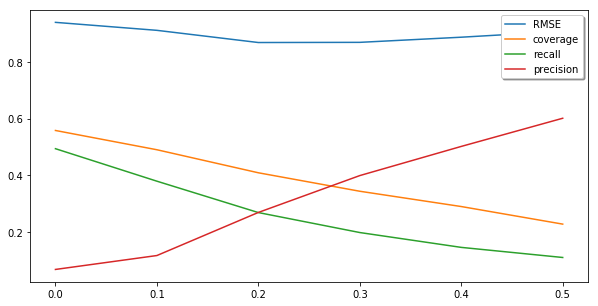

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201516 entries, 1302 to 5151112
Data columns (total 2 columns):
user_id2    201516 non-null int64
item_id2    201516 non-null int64
dtypes: int64(2)
memory usage: 4.6 MB
num of user 2865
num of item 6038
when benchmark = 0.0, coverage =0.5582386363636364, RMSE=0.9401589713482179,recall=0.49388858941173924,precision=0.06732584820495495
when benchmark = 0.1, coverage =0.49015317286652077, RMSE=0.911965090589029,recall=0.37908404378390664,precision=0.11646040570687496
when benchmark = 0.2, coverage =0.4087921117502054, RMSE=0.8689122266151852,recall=0.26827392286864493,precision=0.2686822944935038
when benchmark = 0.3, coverage =0.34355534259702925, RMSE=0.869518430257746,recall=0.19768951929587308,precision=0.3989141492726481
when benchmark = 0.4, coverage =0.28955049620548745, RMSE=0.8876923116092037,recall=0.14526274934289782,precision=0.5019103272008592
when benchmark = 0.5, coverage =0.22744503411675512, RMSE=0.9084495091589441,recall

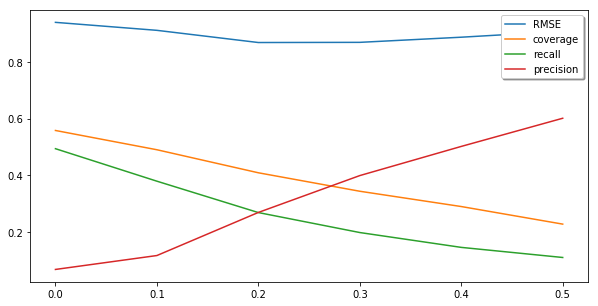

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201516 entries, 1302 to 5151112
Data columns (total 2 columns):
user_id2    201516 non-null int64
item_id2    201516 non-null int64
dtypes: int64(2)
memory usage: 4.6 MB
num of user 2865
num of item 6038
when benchmark = 0.0, coverage =0.5582386363636364, RMSE=0.9401589713482179,recall=0.49388858941173924,precision=0.06732584820495495
when benchmark = 0.1, coverage =0.49015317286652077, RMSE=0.911965090589029,recall=0.37908404378390664,precision=0.11646040570687496
when benchmark = 0.2, coverage =0.4087921117502054, RMSE=0.8689122266151852,recall=0.26827392286864493,precision=0.2686822944935038
when benchmark = 0.3, coverage =0.34355534259702925, RMSE=0.869518430257746,recall=0.19768951929587308,precision=0.3989141492726481
when benchmark = 0.4, coverage =0.28955049620548745, RMSE=0.8876923116092037,recall=0.14526274934289782,precision=0.5019103272008592
when benchmark = 0.5, coverage =0.22744503411675512, RMSE=0.9084495091589441,recall

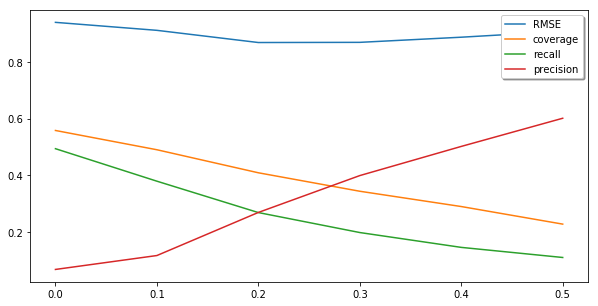

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201516 entries, 1302 to 5151112
Data columns (total 2 columns):
user_id2    201516 non-null int64
item_id2    201516 non-null int64
dtypes: int64(2)
memory usage: 4.6 MB
num of user 2865
num of item 6038
when benchmark = 0.0, coverage =0.5582386363636364, RMSE=0.9401589713482179,recall=0.49388858941173924,precision=0.06732584820495495
when benchmark = 0.1, coverage =0.49015317286652077, RMSE=0.911965090589029,recall=0.37908404378390664,precision=0.11646040570687496
when benchmark = 0.2, coverage =0.4087921117502054, RMSE=0.8689122266151852,recall=0.26827392286864493,precision=0.2686822944935038
when benchmark = 0.3, coverage =0.34355534259702925, RMSE=0.869518430257746,recall=0.19768951929587308,precision=0.3989141492726481
when benchmark = 0.4, coverage =0.28955049620548745, RMSE=0.8876923116092037,recall=0.14526274934289782,precision=0.5019103272008592
when benchmark = 0.5, coverage =0.22744503411675512, RMSE=0.9084495091589441,recall

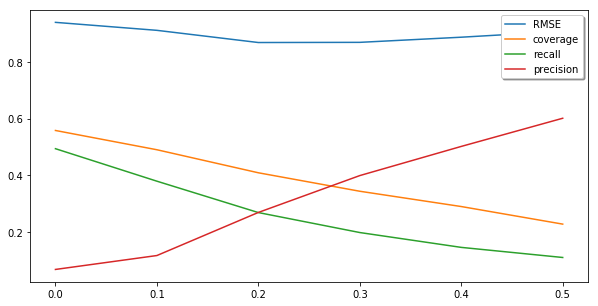

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201516 entries, 1302 to 5151112
Data columns (total 2 columns):
user_id2    201516 non-null int64
item_id2    201516 non-null int64
dtypes: int64(2)
memory usage: 4.6 MB
num of user 2865
num of item 6038
when benchmark = 0.0, coverage =0.5582386363636364, RMSE=0.9401589713482179,recall=0.49388858941173924,precision=0.06732584820495495
when benchmark = 0.1, coverage =0.49015317286652077, RMSE=0.911965090589029,recall=0.37908404378390664,precision=0.11646040570687496
when benchmark = 0.2, coverage =0.4087921117502054, RMSE=0.8689122266151852,recall=0.26827392286864493,precision=0.2686822944935038
when benchmark = 0.3, coverage =0.34355534259702925, RMSE=0.869518430257746,recall=0.19768951929587308,precision=0.3989141492726481
when benchmark = 0.4, coverage =0.28955049620548745, RMSE=0.8876923116092037,recall=0.14526274934289782,precision=0.5019103272008592
when benchmark = 0.5, coverage =0.22744503411675512, RMSE=0.9084495091589441,recall

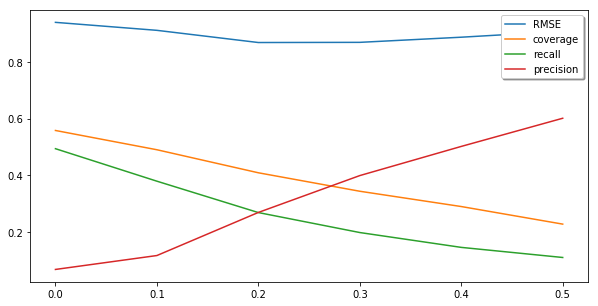

when benchmark = 0.0, coverage =0.5582386363636364, RMSE=0.9401589713482179,recall=0.49388858941173924,precision=0.06732584820495495
when benchmark = 0.1, coverage =0.49015317286652077, RMSE=0.9119650905890289,recall=0.37908404378390664,precision=0.11646040570687496
when benchmark = 0.2, coverage =0.4087921117502054, RMSE=0.8689122266151852,recall=0.26827392286864493,precision=0.2686822944935038
when benchmark = 0.3, coverage =0.34355534259702925, RMSE=0.8695184302577459,recall=0.19768951929587308,precision=0.3989141492726481
when benchmark = 0.4, coverage =0.28955049620548745, RMSE=0.8876923116092037,recall=0.14526274934289782,precision=0.5019103272008592
when benchmark = 0.5, coverage =0.22744503411675515, RMSE=0.9084495091589441,recall=0.10958000100376264,precision=0.6013926289616657


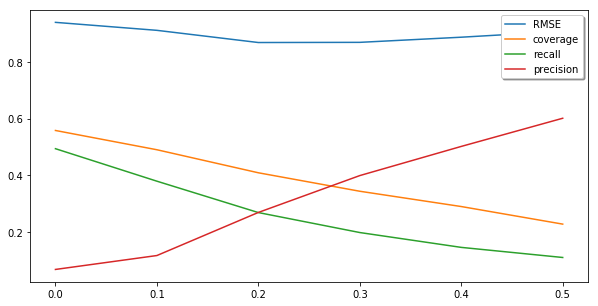

In [6]:
crossvalidation(5,3000,0.7,100)